In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [2]:
data=pd.read_csv(r"C:\Users\86130\00.Project\03.Datasets\Merged_SectorType1209.csv")

In [3]:
data.head()

,Unnamed: 0,SectorType,AvgMaxPower,AvgMinPower,date,max temperature,min temperature
0,0,Large industrial electricity,117888.3300,51526.5690,1/1/2019,12.0,7.0
1,1,business electricity,64027.8582,23758.7970,1/1/2019,12.0,7.0
2,2,general industry,6179.9364,4093.0467,1/1/2019,12.0,7.0
3,3,general industry,10711.9704,3971.5308,1/2/2019,11.0,6.0
4,4,business electricity,75467.2143,20231.6265,1/2/2019,11.0,6.0


In [4]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
data.head()

,SectorType,AvgMaxPower,AvgMinPower,date,max temperature,min temperature
0,Large industrial electricity,117888.3300,51526.5690,1/1/2019,12.0,7.0
1,business electricity,64027.8582,23758.7970,1/1/2019,12.0,7.0
2,general industry,6179.9364,4093.0467,1/1/2019,12.0,7.0
3,general industry,10711.9704,3971.5308,1/2/2019,11.0,6.0
4,business electricity,75467.2143,20231.6265,1/2/2019,11.0,6.0


In [6]:
data['date'] = pd.to_datetime(data['date'], format='%m/%d/%Y')
data.set_index('date', inplace=True)

In [7]:
# 选择特定的行业类型，例如 'Large industrial electricity'
sector_data = data[data['SectorType'] == 'Large industrial electricity']

In [8]:
# 使用最大和最小温度的平均值作为外部变量
sector_data['AvgTemp'] = (sector_data['max temperature'] + sector_data['min temperature']) / 2

C:\Users\86130\AppData\Local\Temp\ipykernel_8048\3168090002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sector_data['AvgTemp'] = (sector_data['max temperature'] + sector_data['min temperature']) / 2


In [9]:
# 准备SARIMAX模型需要的数据
ts_data_max = sector_data[['AvgMaxPower', 'AvgTemp']]
ts_data_min = sector_data[['AvgMinPower', 'AvgTemp']]

In [10]:
# 自动寻找最佳模型参数
auto_model_max = auto_arima(ts_data_max['AvgMaxPower'], exogenous=ts_data_max[['AvgTemp']], seasonal=True, m=12)
auto_model_min = auto_arima(ts_data_min['AvgMinPower'], exogenous=ts_data_min[['AvgTemp']], seasonal=True, m=12)

In [11]:
auto_model_max.order

(3, 0, 5)

In [12]:
auto_model_max.seasonal_order

(0, 0, 2, 12)

In [13]:
auto_model_min.order

(4, 0, 4)

In [14]:
auto_model_min.seasonal_order

(0, 0, 0, 12)

In [15]:
# 获取最佳模型参数
best_order_max = auto_model_max.order
best_seasonal_order_max = auto_model_max.seasonal_order
best_order_min = auto_model_min.order
best_seasonal_order_min = auto_model_min.seasonal_order

In [16]:
# 定义并拟合最佳SARIMAX模型
sarimax_max = SARIMAX(ts_data_max['AvgMaxPower'], exog=ts_data_max['AvgTemp'], order=best_order_max, seasonal_order=best_seasonal_order_max)
fitted_model_max = sarimax_max.fit(disp=False)

C:\Users\86130\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86130\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
sarimax_min = SARIMAX(ts_data_min['AvgMinPower'], exog=ts_data_min['AvgTemp'], order=best_order_min, seasonal_order=best_seasonal_order_min)
fitted_model_min = sarimax_min.fit(disp=False)

C:\Users\86130\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86130\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86130\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\86130\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [18]:
predicted_max = fitted_model_max.get_prediction(exog=ts_data_max['AvgTemp']).predicted_mean
predicted_min = fitted_model_min.get_prediction(exog=ts_data_min['AvgTemp']).predicted_mean

In [35]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
# 计算性能指标
# 对于最大平均用电量
rmse_max = np.sqrt(mean_squared_error(ts_data_max['AvgMaxPower'], predicted_max))
mae_max = mean_absolute_error(ts_data_max['AvgMaxPower'], predicted_max)
r2_max = r2_score(ts_data_max['AvgMaxPower'], predicted_max)
mse_max = mean_squared_error(ts_data_max['AvgMaxPower'], predicted_max)
# 对于最小平均用电量
rmse_min = np.sqrt(mean_squared_error(ts_data_min['AvgMinPower'], predicted_min))
mae_min = mean_absolute_error(ts_data_min['AvgMinPower'], predicted_min)
r2_min = r2_score(ts_data_min['AvgMinPower'], predicted_min)
mse_min = mean_squared_error(ts_data_min['AvgMinPower'], predicted_min)
# 打印性能指标
print("Avg Max Power Usage Performance:")
print(f"RMSE: {rmse_max}, MAE: {mae_max}, R²: {r2_max},MSE:{mse_max}")

print("\nAvg Min Power Usage Performance:")
print(f"RMSE: {rmse_min}, MAE: {mae_min}, R²: {r2_min},MSE:{mse_min}")


Avg Max Power Usage Performance:
RMSE: 11869.71856521503, MAE: 8452.04292912137, R²: 0.8238114914100683,MSE:140890218.81741032

Avg Min Power Usage Performance:
RMSE: 17750.940090709104, MAE: 10628.28168134327, R²: 0.5760318959007016,MSE:315095874.10394377


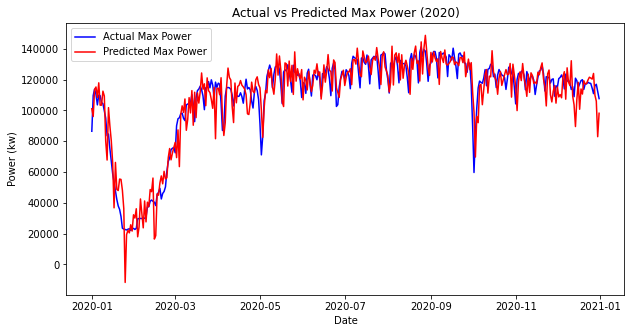

In [24]:
import matplotlib.pyplot as plt
start_date = '2020-01-01'
end_date = '2020-12-31'

actual_max_2020 = ts_data_max['AvgMaxPower'][start_date:end_date]
predicted_max_2020 = predicted_max[start_date:end_date]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(actual_max_2020.index, actual_max_2020, label='Actual Max Power', color='blue')
plt.plot(predicted_max_2020.index, predicted_max_2020, label='Predicted Max Power', color='red')
# plt.fill_between is not used here as confidence intervals are not defined in the provided script
plt.title('Actual vs Predicted Max Power (2020)')
plt.xlabel('Date')
plt.ylabel('Power (kw)')
plt.legend()
plt.show()

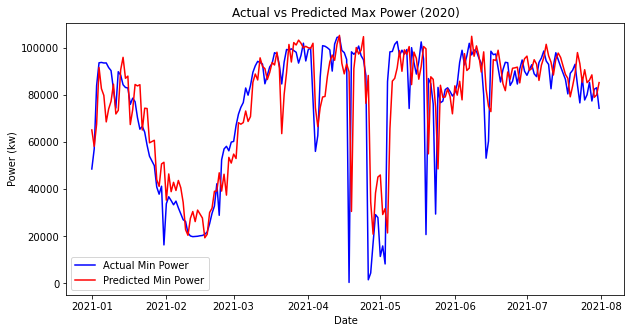

In [25]:
start_date = '2021-01-01'
end_date = '2021-7-31'

actual_min_2020 = ts_data_min['AvgMinPower'][start_date:end_date]
predicted_min_2020 = predicted_min[start_date:end_date]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(actual_min_2020.index, actual_min_2020, label='Actual Min Power', color='blue')
plt.plot(predicted_min_2020.index, predicted_min_2020, label='Predicted Min Power', color='red')
# plt.fill_between is not used here as confidence intervals are not defined in the provided script
plt.title('Actual vs Predicted Max Power (2020)')
plt.xlabel('Date')
plt.ylabel('Power (kw)')
plt.legend()
plt.show()

In [26]:
# 预测未来30天
forecast_max = fitted_model_max.get_forecast(steps=30, exog=ts_data_max['AvgTemp'][-30:])
forecast_min = fitted_model_min.get_forecast(steps=30, exog=ts_data_min['AvgTemp'][-30:])


C:\Users\86130\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\86130\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\86130\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [27]:
# 获取预测结果
forecast_max_power = forecast_max.predicted_mean
forecast_min_power = forecast_min.predicted_mean

In [28]:
# 输出预测结果
print("AvgMaxPower Forecast:\n", forecast_max_power)
print("\nAvgMinPower Forecast:\n", forecast_min_power)

AvgMaxPower Forecast:
 973     107469.070798
974     107331.456171
975     102206.786030
976     108695.393987
977     105943.637171
978     108740.162187
979     110449.787734
980     116366.364076
981     104955.520458
982     112375.521107
983     111644.525614
984     116165.972609
985     115074.447750
986     111544.909811
987     114820.130220
988     122162.335255
989     126913.326790
990     115566.425109
991     123438.490637
992     128122.070317
993     127907.476396
994     128664.326618
995     129098.746278
996     120619.008729
997     127750.944957
998     125900.171226
999     121686.138747
1000    117502.159755
1001    124620.182115
1002    120460.219561
Name: predicted_mean, dtype: float64

AvgMinPower Forecast:
 973     80663.962234
974     82107.991128
975     77967.079709
976     82202.552645
977     81138.483144
978     83373.054053
979     84052.998272
980     87802.462893
981     80215.238521
982     85637.121581
983     84461.664500
984     88210.816691
985 

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
#data['date'] = pd.to_datetime(data['date'])
#data.set_index('date', inplace=True)

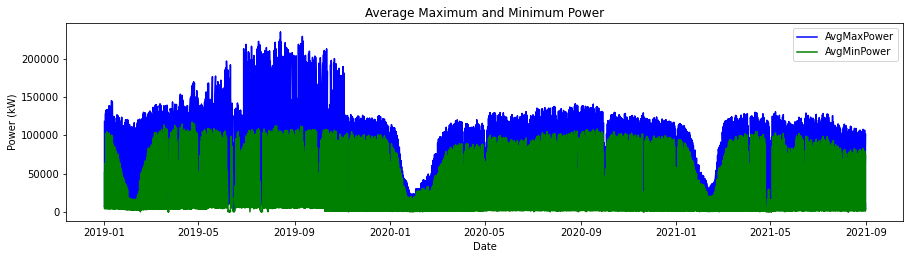

In [31]:
plt.figure(figsize=(15, 8))

# Plotting AvgMaxPower and AvgMinPower
plt.subplot(2, 1, 1)
plt.plot(data.index, data['AvgMaxPower'], label='AvgMaxPower', color='blue')
plt.plot(data.index, data['AvgMinPower'], label='AvgMinPower', color='green')
plt.title('Average Maximum and Minimum Power')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()

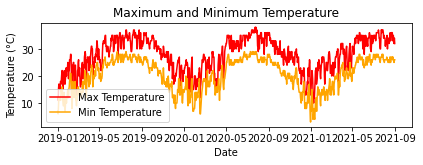

In [32]:
# Plotting Max Temperature and Min Temperature
plt.subplot(2, 1, 2)
plt.plot(data.index, data['max temperature'], label='Max Temperature', color='red')
plt.plot(data.index, data['min temperature'], label='Min Temperature', color='orange')
plt.title('Maximum and Minimum Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
last_date = pd.to_datetime('2021-09-01')  # Replace with your last date
forecast_dates = pd.date_range(start=last_date, periods=31, closed='right')

C:\Users\86130\AppData\Local\Temp\ipykernel_8048\1433218771.py:2: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(start=last_date, periods=31, closed='right')


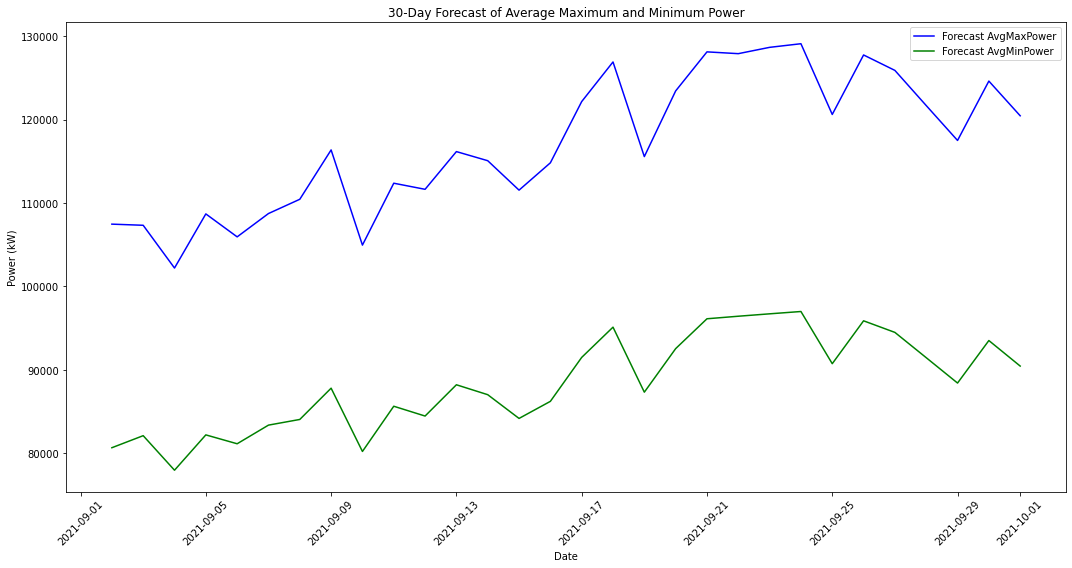

In [34]:
plt.figure(figsize=(15, 8))

# Plotting AvgMaxPower Forecast
plt.plot(forecast_dates, forecast_max_power, label='Forecast AvgMaxPower', color='blue')

# Plotting AvgMinPower Forecast
plt.plot(forecast_dates, forecast_min_power, label='Forecast AvgMinPower', color='green')

plt.title('30-Day Forecast of Average Maximum and Minimum Power')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.xticks(rotation=45)  # Rotating date labels for better readability
plt.tight_layout()
plt.show()

In [40]:
# 定义并拟合SARIMAX模型
#sarimax_model_max = SARIMAX(ts_data_max['AvgMaxPower'], exog=ts_data_max['AvgTemp'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
#fitted_model_max = sarimax_model_max.fit(disp=False)

In [41]:
#sarimax_model_min = SARIMAX(ts_data_min['AvgMinPower'], exog=ts_data_min['AvgTemp'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
#fitted_model_min = sarimax_model_min.fit(disp=False)

In [39]:

#forecast_max = fitted_model_max.get_forecast(steps=30, exog=ts_data_max['AvgTemp'][-30:])
#forecast_min = fitted_model_min.get_forecast(steps=30, exog=ts_data_min['AvgTemp'][-30:])


In [13]:
# 获取预测结果
#forecast_max_power = forecast_max.predicted_mean
#forecast_min_power = forecast_min.predicted_mean

In [37]:
# 打印预测结果
#print("AvgMaxPower Forecast:\n", forecast_max_power)
#print("\nAvgMinPower Forecast:\n", forecast_min_power)